In [9]:
################ FUNCTIONS
import math
%pylab inline
import pylab
from scipy.optimize import fsolve

# Uses the Haversine formula to calculate the distance (in meters) between 
# two points given their longitude and latitude in decimal format.
# The Haversine function is defined as: hav(theta) = sin^2(theta/2)
# From: https://en.wikipedia.org/wiki/Haversine_formula
# & https://rosettacode.org/wiki/Haversine_formula#Python
def haverDist(lat1, long1, lat2, long2):
    R      = 6.371009e6 # Earths Radius (m) or 6371.009 (km) or 3958.7613 (miles)
    Long1  = math.radians(long1)
    Lat1   = math.radians(lat1)
    Long2  = math.radians(long2)
    Lat2   = math.radians(lat2)
    dLat   = Lat2 - Lat1
    dLong  = Long2 - Long1 
    eqn1   = math.sin(dLat/2)**2 + math.cos(Lat1)*math.cos(Lat2)*math.sin(dLong/2)**2
    HavDis = R*2*math.atan2(math.sqrt(eqn1), math.sqrt(1-eqn1)) # atan2(y,x) = atan(y/x)
    return HavDis

def haverDist2(lat_long1, lat_long2):
    lat1, long1 = lat_long1
    lat2, long2 = lat_long2
    return haverDist(lat1, long1, lat2, long2)

# Convert Lat, Lon, Altitude to Earth-Centered-Earth-Fixed (ECEF)
# Returns x, y, z in meters. Assumes the elevation to be in feet and then converts it to meters.
# SOURCE: http://danceswithcode.net/engineeringnotes/geodetic_to_ecef/geodetic_to_ecef.html
# TEST ACCURACY: https://www.oc.nps.edu/oc2902w/coord/llhxyz.htm?source=post_page---------------------------
def LatLon2xyz(lat, lon, alt):
    alt   = 0.3048*alt              # Convert elevation from feet to meters
    lat   = d2R(lat)                # Convert degrees to radians
    lon   = d2R(lon)                # Convert degrees to radians
    ec    = 6.6943799901377997e-3   # WGS-84 first eccentricity squared
    a     = 6378137.0               # WGS-84 semi-major axis
    Erad  = 6.371009e6              # Earths radius in meters
    n     = a/math.sqrt(1 - ec*math.sin(lat)*math.sin(lat))
    ecefX = (n + alt)*math.cos(lat)*math.cos(lon)
    ecefY = (n + alt)*math.cos(lat)*math.sin(lon)
    ecefZ = (n*(1 - ec) + alt)*math.sin(lat)
    return('%.3f'%ecefX, '%.3f'%ecefY, '%.3f'%ecefZ)

# Use this function to convert x,y,z back to Lat, Lon, Altitude respectively
# Assumes all x,y,z values are in meters and returns Altitude in meters
# SOURCE: http://danceswithcode.net/engineeringnotes/geodetic_to_ecef/geodetic_to_ecef.html
def xyz2LatLon(x, y, z):
    a  = 6378137.0              # WGS-84 semi-major axis
    e2 = 6.6943799901377997e-3  # WGS-84 first eccentricity squared
    a1 = 4.2697672707157535e+4  # a1 = a*e2
    a2 = 1.8230912546075455e+9  # a2 = a1*a1
    a3 = 1.4291722289812413e+2  # a3 = a1*e2/2
    a4 = 4.5577281365188637e+9  # a4 = 2.5*a2
    a5 = 4.2840589930055659e+4  # a5 = a1+a3
    a6 = 9.9330562000986220e-1  # a6 = 1-e2
    w2 = x*x + y*y 
    w  = math.sqrt(w2)
    r2 = w2 + z*z
    r  = math.sqrt(r2)
    Lon = math.atan2(y, x) # Lon 
    s2 = z*z/r2
    c2 = w2/r2
    u = a2/r
    v = a3 - (a4/r)
    if(c2 > 0.3):
        s = (math.sqrt(z**2)/r)*(1.0 + c2*(a1+u+s2*v)/r) # z shouid be positive |z|
        Lat = math.asin(s) # Lat
        ss = s*s
        c = math.sqrt(1.0-ss)
    else:
        c = (w/r)*(1.0 - s2*(a5-u-c2*v)/r)
        Lat = math.acos(c) # Lat
        ss = 1.0 - c*c
        s = math.sqrt(ss)
    rg = a/math.sqrt(1.0 - e2*ss)
    rf = a6*rg
    u = w - rg*c
    v = math.sqrt(z**2) - rf*s # z shouid be positive |z|
    f = c*u + s*v
    m = c*v - s*u
    p = m/((rf/(1.0 - e2*ss))+f) 
    Lat = Lat + p # Lat
    Alt = f + m*p/2.0 # Altitude
    if( z < 0.0 ):
        Lat *= -1.0 # Lat
    Lat = (180.0/math.pi)*Lat
    Lon = (180.0/math.pi)*Lon
    return('%.7f'%Lat, '%.7f'%Lon, '%.3f'%Alt) # Return Lat, Lon, Altitude in that order

# Uses the distance formula to solve for the distance between the Receiver & Transmitter with  
# the purpose of using these distances to find ratios. Assumes that all inputs are in the 
# x,y,z format and the units are in meters.
def ShortestPath(xTran, yTran, zTran, xRec, yRec, zRec):
    # Cartesian Distance Formula for 3-Dimensions
    R = math.sqrt((xTran - (xRec))**2 + (yTran - (yRec))**2 + (zTran - (zRec))**2)
    return R

def Rpath(LatT, LonT, LatR, LonR, Hght):
    # Adjacent length (b) of right triangle (distance from Tx to the base of the building Rx)
    b = haverDist(LatR, LonR, LatT, LonT) 
    a = 0.3048*Hght # Opposite length (a) of right triangle (building height converted from feet to meters)
    # solving for the hypotenuse (R) of right triangle (direct distance between Tx & Rx)
    R = math.sqrt(a**2 + b**2) 
    return R

def d2R(x): # Convert degrees to radians
    rad = x*(math.pi/180.0)
    return rad

def f2M(x): # converts feet to meters 
    Meter = 0.3048*x
    return Meter

def m2Km(x): #Convert meters to kilometers 
    km = 0.001*x
    return km

def Gps2Dec(degrees, minutes, seconds): # Converts GPS coordinates to Lat and Long in decimal
    D = float(degrees) + float(minutes)/60 + float(seconds)/(60*60)
    return D

Populating the interactive namespace from numpy and matplotlib


/home/jon/.local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [10]:
################ EQUATIONS 
# Modified function originally written by David DeTienne 801-209-0802, david.detienne@raytheon.

def eqns1(p): # Receivers: Behavioral Science or BEHS(0), Browning(1), Dentistry(2)
    global gam01,gam12,x0,y0,z0,x1,y1,z1,x2,y2,z2
    x,y = p 
    return (gam01*((x0-x)**2+(y0-y)**2+(z0-0)**2)-(x1-x)**2-(y1-y)**2-(z1-0)**2, # Transmitter z = 0
            gam12*((x1-x)**2+(y1-y)**2+(z1-0)**2)-(x2-x)**2-(y2-y)**2-(z2-0)**2)

def eqns2(p): # Receivers: Honors Dorm(4), South Medical Tower(6), SMBB(7)
    global gam76, gam64, x4, x6, x7, y4, y6, y7, z6, z7
    x,y = p 
    return (gam76*((x7-x)**2+(y7-y)**2+(z7-0)**2)-(x6-x)**2-(y6-y)**2-(z6-0)**2, # Transmitter z = 0
            gam64*((x6-x)**2+(y6-y)**2+(z6-0)**2)-(x4-x)**2-(y4-y)**2-(z4-0)**2)

def eqns3(p): # Receivers: Browning(1), Honors Dorm(4), SMBB(7)  
    global gam41, gam17,x1, x4, x7, y1, y4, y7, z4, z1
    x,y = p 
    return (gam41*((x4-x)**2+(y4-y)**2+(z4-0)**2)-(x1-x)**2-(y1-y)**2-(z1-0)**2, # Transmitter z = 0
            gam17*((x1-x)**2+(y1-y)**2+(z1-0)**2)-(x7-x)**2-(y7-y)**2-(z7-0)**2)

def eqns4 (p):
    global x4, y4, z4, x6, y6, z6, x7, y7, z7, gam46, gam67
    x, y = p
    return(gam46*((x4-x)**2+(y4-y)**2+(z4-0)**2)-(x6-x)**2-(y6-y)**2-(z6-0)**2,
           gam67*((x6-x)**2+(y6-y)**2+(z6-0)**2)-(x7-x)**2-(y7-y)**2-(z7-0)**2)

In [11]:
############## RECEIVER DICTIONARY 
# Receive Tower Dictionary for Lat, Lon & Elevation respectively. Elevation is in feet.
Receivers = { 
    'Honors': (40.7643944, -111.8369806), #, 4822.0), # Building Height: 70ft
    'BEHS': (40.7615389, -111.8463778), #, 4681.0), # Building Height: 154ft
    'FriendshipManor': (40.7580028, -111.8531639), #, 4572.0), # Building Height: 156ft
    'SMBB': (40.7689500, -111.8418944), #, 4822.0), # Building Height: 72ft
    'SouthMedical': (40.7674472, -111.8313139), #, 4947.0), # Building Height: 123ft
    'Browning': (40.7662472, -111.8475389), #, 4711.0), # Building Height: 98ft
    'MEB': (40.7685861, -111.8446944), #, 4753.0), # Building Height: 42ft
    'Dentistry': (40.7571833, -111.8315111), #, 4810.0), # Building Height: 53ft
}

# Receive Tower Dictionary for x,y,z coordinates with respect to center of earth, all units are in meters.
ReceiversXyz = {
    'Honors': LatLon2xyz(40.7643944, -111.8369806, 4822.0 + 70.0), # Building Height: 70ft
    'BEHS': LatLon2xyz(40.7615389, -111.8463778, 4681.0 + 154.0), # Building Height: 154ft
    'FriendshipManor': LatLon2xyz(40.7580028, -111.8531639, 4572.0 + 156.0), # Building Height: 156ft
    'SMBB': LatLon2xyz(40.7689500, -111.8418944, 4822.0 + 72.0), # Building Height: 72ft
    'SouthMedical': LatLon2xyz(40.7674472, -111.8313139, 4947.0 + 123.0), # Building Height: 123ft
    'Browning': LatLon2xyz(40.7662472, -111.8475389, 4711.0 + 98.0), # Building Height: 98ft
    'MEB': LatLon2xyz(40.7685861, -111.8446944, 4753.0 + 42.0), # Building Height: 42ft
    'Dentistry': LatLon2xyz(40.7571833, -111.8315111, 4810.0 + 53.0), # Building Height: 53ft    
}

print 'Honors to x,y,z', ReceiversXyz['Honors']
print 'BEHS to x,y,z', ReceiversXyz['BEHS']
print 'Friendship Manor to x,y,z', ReceiversXyz['FriendshipManor']
print 'SMBB to x,y,z', ReceiversXyz['SMBB']
print 'South Medical to x,y,z', ReceiversXyz['SouthMedical']
print 'Browning to x,y,z', ReceiversXyz['Browning']
print 'MEB to x,y,z', ReceiversXyz['MEB']
print 'Dentistry to x,y,z', ReceiversXyz['Dentistry']

Honors to x,y,z ('-1799890.857', '-4491638.317', '4143615.053')
BEHS to x,y,z ('-1800699.683', '-4491523.060', '4143363.475')
Friendship Manor to x,y,z ('-1801317.903', '-4491524.834', '4143044.676')
SMBB to x,y,z ('-1800153.303', '-4491177.668', '4143998.694')
South Medical to x,y,z ('-1799379.555', '-4491648.915', '4143907.302')
Browning to x,y,z ('-1800661.395', '-4491164.049', '4143754.405')
MEB to x,y,z ('-1800374.099', '-4491092.978', '4143948.377')
Dentistry to x,y,z ('-1799654.061', '-4492289.353', '4143002.590')


In [12]:
############## TRANSMIT DICTIONARY 
# Transmit Locations in Lat & Lon
lat_long = { 
    'TxLegBridge': (40.765037, -111.837156), #, 4872.0), # 4872 ft in elevation
    'TxMechBridge': (40.767450, -111.847209), #, 4747.0), # 4747 ft in elevation
    'TxPrimaryChildrens': (40.769258, -111.839854), #, 4834.0), # 4834 ft in elevation
    'TxPrimaryChildrens2': (40.769177, -111.839733), #, 4834.0),  # 4834 ft in elevation
    'TxBeh': (40.761671,-111.846444), #, 4681.0), 
    'TxHonors': (40.763942,-111.836838), #, 4821.0), # 4821 ft in elevation 
    'TxBrowning': (40.766509, -111.847175), #, 4711.0),
    'TxMebParkingLot': (40.768976, -111.846548), #, 4750.0), 
    'TxMcarthyField': (40.766360, -111.839262) #, 4820)
} 

# Transmit Locations converted from Lat & Lon to x,y,z 
MsrdPwrXyz = {  
    'TxLegBridge': LatLon2xyz(40.765037, -111.837156, 4872.0), # 4872 ft in elevation
    'TxMechBridge': LatLon2xyz(40.767450, -111.847209, 4747.0), # 4747 ft in elevation
    'TxPrimaryChildrens': LatLon2xyz(40.769258, -111.839854, 4834.0), # 4834 ft in elevation
    'TxPrimaryChildrens2': LatLon2xyz(40.769177, -111.839733, 4834.0),  # 4834 ft in elevation
    'TxBeh': LatLon2xyz(40.761671,-111.846444, 4681.0), 
    'TxHonors': LatLon2xyz(40.763942,-111.836838, 4821.0), # 4821 ft in elevation 
    'TxBrowning': LatLon2xyz(40.766509, -111.847175, 4711.0),
    'TxMebParkingLot': LatLon2xyz(40.768976, -111.846548, 4750.0), 
    'TxMcarthyField': LatLon2xyz(40.766360, -111.839262, 4820.0),
}

print 'Tx LegBridge to x,y,z:', MsrdPwrXyz['TxLegBridge']
print 'Tx MechBridge to x,y,z:', MsrdPwrXyz['TxMechBridge']
print 'Tx PrimaryChildrens to x,y,z:', MsrdPwrXyz['TxPrimaryChildrens']
print 'Tx PrimaryChildrens2 to x,y,z:', MsrdPwrXyz['TxPrimaryChildrens2']
print 'Tx Beh to x,y,z:', MsrdPwrXyz['TxBeh']
print 'Tx Honors to x,y,z:', MsrdPwrXyz['TxHonors']
print 'Tx Browning x,y,z:', MsrdPwrXyz['TxBrowning']
print 'Tx MebParkingLot to x,y,z:', MsrdPwrXyz['TxMebParkingLot']
print 'Tx McarthyField to x,y,z:', MsrdPwrXyz['TxMcarthyField']
print '---------------------------------------------------------'

# Wednesday, Nov 20th 2019 Calcualtions with david and alex. The powers might have to be scaled by some factor 
Dist1 = haverDist2(lat_long['TxBeh'], lat_long['TxBrowning'])
Dist2 = haverDist2(lat_long['TxBrowning'], lat_long['TxHonors'])
print('Distance between BHS and Browning', '%.4f'%Dist1)
print('Distance between Honors and Browning', '%.4f'%Dist2)
p = -30.837990 - (-49.849045)
pwr_ratio = (10.0)**(p/10.0)
print 'Power Ratio', '%.4f'%pwr_ratio
gam=(Dist2**2)/(Dist1**2)
print "Gamma1,2:", '%.4f'%gam

Tx LegBridge to x,y,z: ('-1799885.554', '-4491585.259', '4143665.133')
Tx MechBridge to x,y,z: ('-1800597.744', '-4491080.159', '4143843.251')
Tx PrimaryChildrens to x,y,z: ('-1799979.900', '-4491208.178', '4144012.661')
Tx PrimaryChildrens2 to x,y,z: ('-1799972.601', '-4491217.433', '4144005.847')
Tx Beh to x,y,z: ('-1800688.077', '-4491479.087', '4143343.941')
Tx Honors to x,y,z: ('-1799885.786', '-4491658.038', '4143562.862')
Tx Browning x,y,z: ('-1800617.385', '-4491136.863', '4143756.924')
Tx MebParkingLot to x,y,z: ('-1800505.002', '-4490998.839', '4143972.220')
Tx McarthyField to x,y,z: ('-1800010.487', '-4491418.887', '4143766.083')
---------------------------------------------------------
('Distance between BHS and Browning', '541.4731')
('Distance between Honors and Browning', '916.1636')
Power Ratio 79.6353
Gamma1,2: 2.8628


In [13]:
################## RATIOS
# Receive Tower (fixed) Coordinates in meters 
x0, y0, z0 = -1800699.683, -4491523.060, 4143363.475 # ReceiversXyz['BEHS'] 
x1, y1, z1 = -1800661.395, -4491164.049, 4143754.405 # ReceiversXyz['Browning'] 
x2, y2, z2 = -1799654.061, -4492289.353, 4143002.590 # ReceiversXyz['Dentistry']
x3, y3, z3 = -1801317.903, -4491524.834, 4143044.676 # ReceiversXyz['FriendshipManor']  
x4, y4, z4 = -1799890.857, -4491638.317, 4143615.053 # ReceiversXyz['Honors']   
x5, y5, z5 = -1800374.099, -4491092.978, 4143948.377 # ReceiversXyz['MEB'] 
x6, y6, z6 = -1799379.555, -4491648.915, 4143907.302 # ReceiversXyz['SouthMedical'] 
x7, y7, z7 = -1800153.303, -4491177.668, 4143998.694 # ReceiversXyz['SMBB'] 

#xTran, yTran, zTran = -1799972.601, -4491217.433, 4144005.847 # Near Primary Childrens Parking Lot
#xTran, yTran, zTran = -1799979.900, -4491208.178, 4144012.661 # Near Primary Childrens Parking Lot
#  'TxPrimaryChildrens2': LatLon2xyz(40.769177, -111.839733, 4834.0),  # 4834 ft in elevation
xTran, yTran, zTran = -1800010.487, -4491418.887, 4143766.083 # Mcarthy Track & Field


# Calculate ratio 1st Method 
RsMBB = ShortestPath(xTran, yTran, zTran, x7, y7, z7) 
print 'Shortest Path from Tx to SMBB:', RsMBB
# Calculate ratio 2nd Method 
RsMBB2 = Rpath(40.769177, -111.839733, 40.7689500, -111.8418944, 72) # SMBB Bld Hght 72ft 
print 'Second Method (Lat & Lon)', RsMBB2

# Calculate ratio 1st Method 
Rsmt = ShortestPath(xTran, yTran, zTran, x6, y6, z6) 
print 'Shortest Path from Tx to South Medical Tower:', Rsmt
# Calculate ratio 2nd Method 
Rsmt2 = Rpath(40.769177, -111.839733, 40.7674472, -111.8313139, 123) # South Medical Tower Bld Hght 123ft 
print 'Second Method (Lat & Lon)', Rsmt2

# Calculate ratio 1st Method 
Rhd = ShortestPath(xTran, yTran, zTran, x4, y4, z4)  
print 'Shortest Path from Tx to Honors:', Rhd
# Calculate ratio 2nd Method 
Rhd2 = Rpath(40.769177, -111.839733, 40.7643944, -111.8369806, 70) # Honors Bld Hght 70ft
print 'Second Method (Lat & Lon)', Rhd2

# Calculate ratio 1st Method 
Rbrwn = ShortestPath(xTran, yTran, zTran, x1, y1, z1) 
print 'Shortest Path from Tx to Browning:', Rbrwn
# Calculate ratio 2nd Method 
Rbrwn2 = Rpath(40.769177, -111.839733, 40.7662472, -111.8475389, 98) # Browning Bld Hght 98ft 
print 'Second Method (Lat & Lon)', Rbrwn2
print '----------------------------------------------------'

print '___________________________________________________________________________________________'
print 'Calculated Ratio using x,y,z numbers that are in meters'
gam76 = (RsMBB)**2/(Rsmt**2)
print 'Ratio between SMBB and Medical Tower', gam76
gam64 = (Rhd**2)/(RsMBB)**2
print 'Ratio between SMBB and Honors', gam64
gam41 = (Rhd)**2/(Rbrwn**2)
print 'Ratio between Honors and Browning', gam41
gam17 = (RsMBB**2)/(Rbrwn**2)
print 'Ratio between SMBB and Browning', gam17

print '___________________________________________________________________________________________'
print 'Calculated Ratio using Lat & Lon of reference points all measurements are on earths surface'
gam76_2 = (RsMBB2**2)/(Rsmt2**2)
print 'Ratio between SMBB and Medical Tower', gam76_2
gam64_2 = (RsMBB2**2)/(Rhd2**2)
print 'Ratio between SMBB and Honors', gam64_2
gam41_2 = (Rhd2**2)/(Rbrwn2**2)
print 'Ratio between Honors and Browning', gam41_2
gam17_2 = (RsMBB2**2)/(Rbrwn2**2)
print 'Ratio between SMBB and Browning', gam17_2

Shortest Path from Tx to SMBB: 364.267611981
Second Method (Lat & Lon) 185.066337493
Shortest Path from Tx to South Medical Tower: 686.244034851
Second Method (Lat & Lon) 735.591892827
Shortest Path from Tx to Honors: 292.011853698
Second Method (Lat & Lon) 580.515213561
Shortest Path from Tx to Browning: 699.113729226
Second Method (Lat & Lon) 734.278860602
----------------------------------------------------
___________________________________________________________________________________________
Calculated Ratio using x,y,z numbers that are in meters
Ratio between SMBB and Medical Tower 0.281762993421
Ratio between SMBB and Honors 0.642628297113
Ratio between Honors and Browning 0.174463789149
Ratio between SMBB and Browning 0.271484760215
___________________________________________________________________________________________
Calculated Ratio using Lat & Lon of reference points all measurements are on earths surface
Ratio between SMBB and Medical Tower 0.063296688897
Ratio bet

Transmit Location (x,y) m: ('40.8632541', '-111.8780576', '-10980.770')


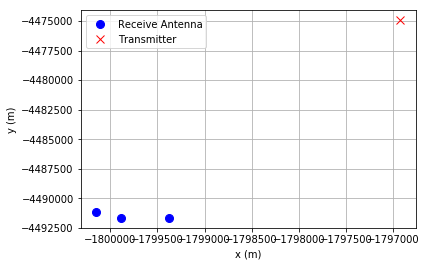

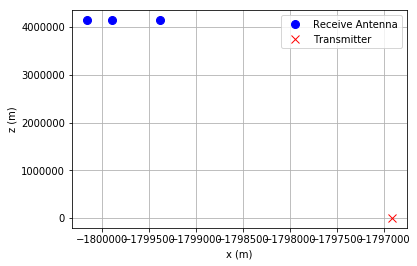

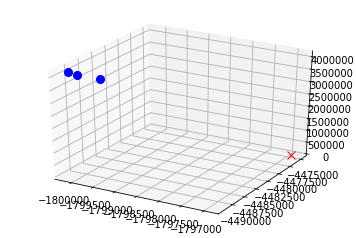

In [14]:
############ PLOTTING
z = 0 # Transmitter stays on the ground
x,y = fsolve(eqns2, (gam76, gam64)) # gam is the power ratio -gam76, -gam64

print 'Transmit Location (x,y) m:', xyz2LatLon(x, y, 4143766.083) # should expect somewhere by primary 
# childrens parking lot like: 40.769258, -111.839854
# MCarthy Field: -1800010.487, -4491418.887, 4143766.083
# lat, lon: 40.766605, -111.839228
pylab.figure()
pylab.plot([x4,x6,x7], [y4,y6,y7], 'bo', markersize=8.0, label='Receive Antenna')
pylab.plot([x], [y], 'rx', markersize=8.0, label='Transmitter')
pylab.xlabel('x (m)')
pylab.ylabel('y (m)')
pylab.legend()
pylab.grid()
pylab.show()

pylab.figure()
pylab.plot([x4,x6,x7], [z4,z6,z7], 'bo', markersize=8.0, label='Receive Antenna')
pylab.plot([x], [z], 'rx', markersize=8.0, label='Transmitter')
pylab.xlabel('x (m)')
pylab.ylabel('z (m)')
pylab.legend()
pylab.grid()
pylab.show()

%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

x,y = fsolve(eqns2, (gam76, gam64)) # gam is the power ratio -gam76, -gam64
fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.plot3D([x4,x6,x7], [y4,y6,y7], [z4,z6,z7], 'bo', markersize=8.0)
ax.plot3D([x], [y], [z], 'rx', markersize = 8.0)
plt.show()  

# Measured from Mcarthy Field  
# Actual: 40.766654, -111.839271